In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

In [2]:
voice = pd.read_csv('voice.csv')
voice['label'] = np.where(voice['label'] == 'male', 1, 0) # male is 1 and female is 0
voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


# Decision Tree

In [3]:
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

X = voice.drop('label', 1)
outcome = voice['label']

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=5,
    max_depth=5,
    random_state=4171
)
model = decision_tree.fit(X, outcome)

In [4]:
# for i in range(len(X.columns)):
#     print('{}: \n{}'.format(X.columns[i], model.feature_importances_[i]))

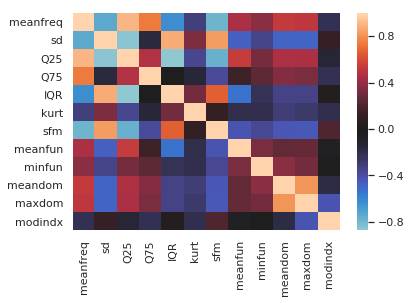

In [5]:
index = np.where(model.feature_importances_>0)
columns = X.columns[index]

X_new = X[columns]

sns.heatmap(X_new.corr(), center=0);

In [6]:
most_corr = abs(X_new.corr().mean()).nlargest(2)
print(most_corr.index)

Index(['Q75', 'meandom'], dtype='object')


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


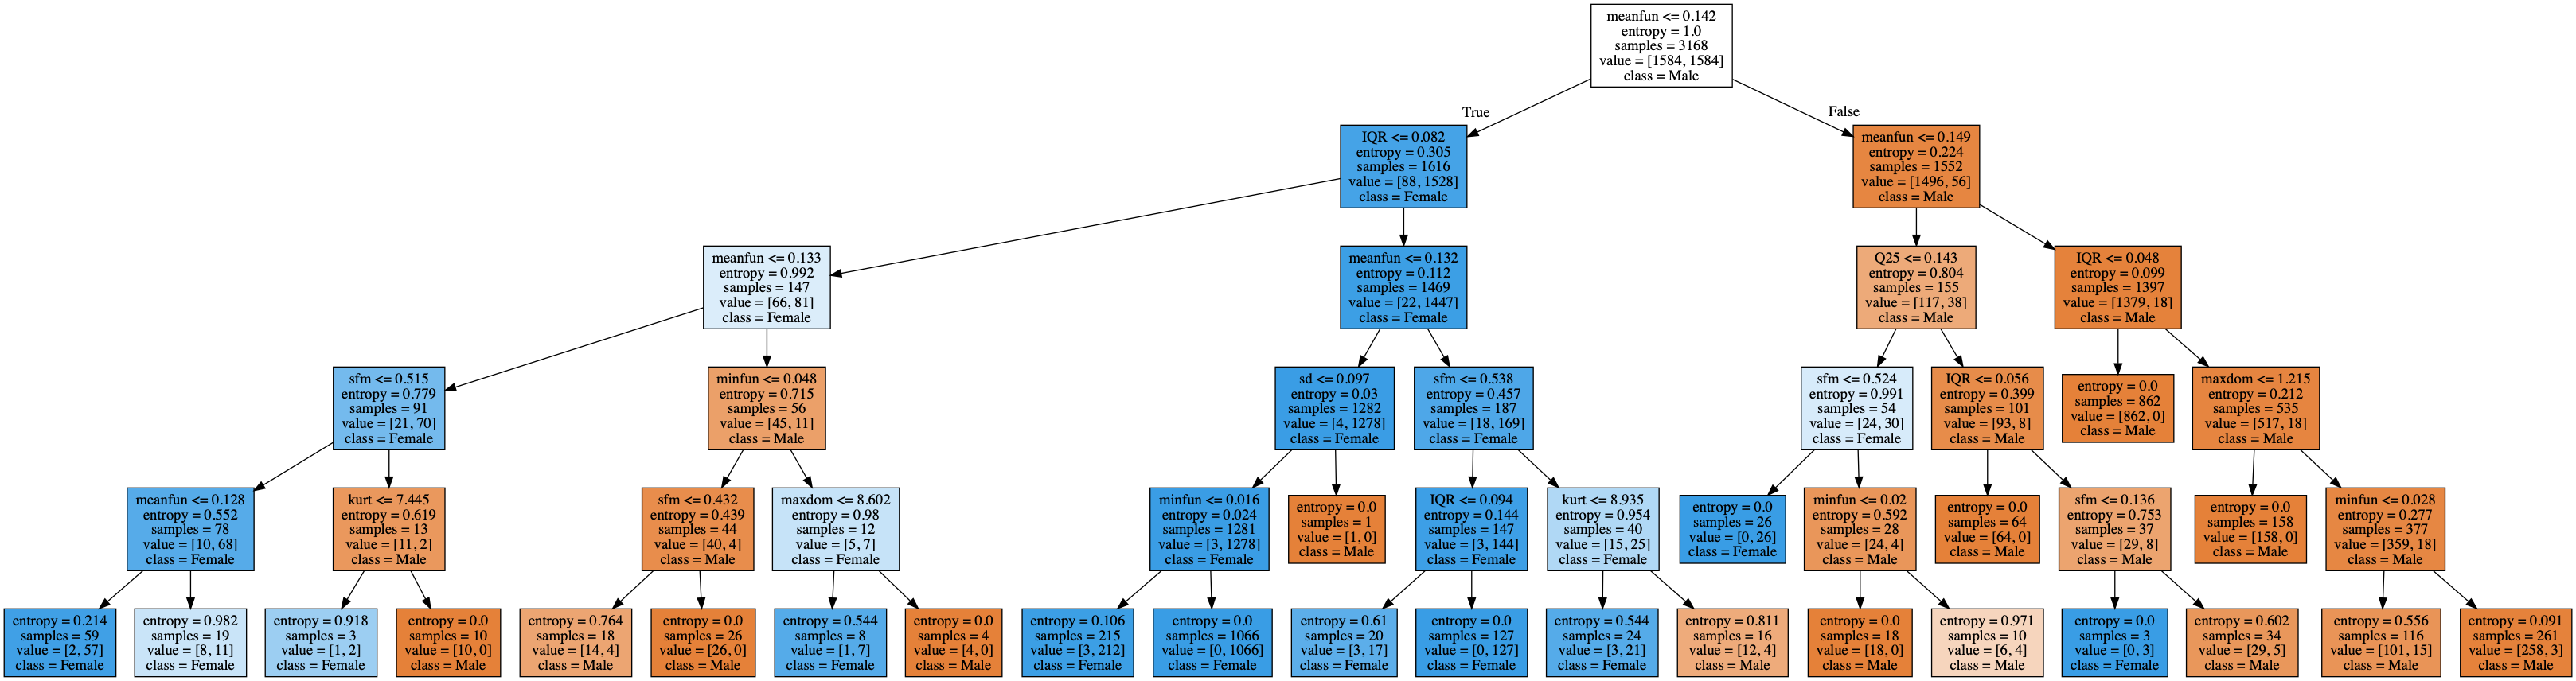

In [7]:
%time
X_new = X_new.drop(most_corr.index, 1)

dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=5,
    max_depth=5,
    random_state = 4171
)

model_new = dt.fit(X_new, outcome)

# Render our tree.
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=X_new.columns,
    class_names=['Male', 'Female'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [8]:
y_pred = model_new.predict(X_new)
#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(X_new.shape[0], (outcome != y_pred).sum()))

print('{:.3}% mislabeled'.format((outcome != y_pred).sum()/X_new.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    X_new.shape[0], 
    (outcome == y_pred).sum()
))

print('Accuracy = {:.4}%'.format((outcome == y_pred).sum()/X_new.shape[0]*100))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(outcome, y_pred)
false_pos = mat[1][0]
false_neg = mat[0][1]
specificity = mat[0][0]/sum(mat[0])
sensitivity = mat[1][1]/sum(mat[1])

print('confustion matrix: \n {}'.format(mat))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('specificity: {:.4}%'.format(specificity*100))
print('sensitivity: {:.4}%'.format(sensitivity*100))

Number of mislabeled points out of a total 3168 points : 56
1.77% mislabeled
Number of correctly identified points out of a total 3168 points : 3112
Accuracy = 98.23%
confustion matrix: 
 [[1563   21]
 [  35 1549]]
false positives: 35
false negatives: 21
specificity: 98.67%
sensitivity: 97.79%


In [9]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(decision_tree, X, outcome, cv=10)
print('old')
print(cv)
print('{:.4}% +/- {:.3}'.format(cv.mean()*100, np.std(cv)*200))

old
[0.91823899 0.93081761 0.95283019 0.90880503 0.95253165 0.98734177
 0.99367089 0.97468354 0.92088608 0.97151899]
95.11% +/- 5.76


In [10]:
cv = cross_val_score(dt, X_new, outcome, cv=10)
print('new')
print(cv)
print('{:.4}% +/- {:.3}'.format(cv.mean()*100, np.std(cv)*200))
%time

new
[0.9245283  0.9591195  0.98113208 0.93710692 0.9556962  0.96518987
 0.99683544 0.97468354 0.92721519 0.98101266]
96.03% +/- 4.63
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs


# Random Forest

In [11]:
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier(random_state=4171)

X_rf = voice.drop('label', 1)
Y_rf = voice['label']

cv = cross_val_score(rfc, X_new, Y_rf, cv=10)
print(cv)
print('\n{:.3} +\- {:.3}%\n'.format(cv.mean()*100, np.std(cv)*200))
%time

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

[0.94025157 0.9591195  0.98427673 0.96226415 0.96835443 0.98734177
 0.99367089 0.99050633 0.9335443  0.99367089]

97.1 +\- 4.21%

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
